In [2]:
import pandas as pd
import numpy as np
import pyodbc
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [4]:
def convertir_tag_rendimiento(value):
    if value == 0:
        return 'EXITOSO'
    elif value == 1:
        return 'NO EXITOSO'
    else:
        return 'ERROR'

In [5]:
conn = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}', SERVER='MED000008696', DATABASE='Difods_Analytics', Trusted_Connection='yes')
cursor = conn.cursor()

datos_estructurados_exitoso = pd.read_sql_query("SELECT TOP(100000) * FROM [Difods_Analytics].dbo.DATA_TRAIN_RNA_FINAL WHERE RENDIMIENTO='EXITOSO'", conn)
datos_estructurados_no_exitoso = pd.read_sql_query("SELECT TOP(100000) * FROM [Difods_Analytics].dbo.DATA_TRAIN_RNA_FINAL WHERE RENDIMIENTO='NO EXITOSO'", conn)

In [6]:
datos_estructurados_total = datos_estructurados_exitoso.append(datos_estructurados_no_exitoso, ignore_index=True)

In [7]:
datos_estructurados_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RENDIMIENTO                      200000 non-null  object 
 1   Descripcion_Cargo                200000 non-null  object 
 2   Descripcion_Subtipo_trabajador   200000 non-null  object 
 3   escala                           200000 non-null  object 
 4   Jornada_Laboral                  200000 non-null  int64  
 5   condicion_laboral                200000 non-null  object 
 6   D_NIV_MOD                        200000 non-null  object 
 7   D_COD_CAR                        200000 non-null  object 
 8   DAREACENSO                       200000 non-null  object 
 9   D_REGION                         200000 non-null  object 
 10  nivel                            200000 non-null  object 
 11  JEC                              200000 non-null  bool   
 12  EI

In [8]:
datos_estructurados_total.head(10)

,RENDIMIENTO,Descripcion_Cargo,Descripcion_Subtipo_trabajador,escala,Jornada_Laboral,condicion_laboral,D_NIV_MOD,D_COD_CAR,DAREACENSO,D_REGION,...,CHOICE,PAGE,ASSIGN,URL,PRUEBA_ENTRADA,FINALGRADE,PUNTAJE_PUN,CONDICION_PUN,FORO_PRESENTACION,PUNTUACION_FORO
0,EXITOSO,PROFESOR,DOCENTE,4,30,NOMBRADO,Inicial - Jardín,No aplica,Urbana,DRE LIMA METROPOLITANA,...,0,1,0,10,1,16.0,0.0,Otro,0,0.0
1,EXITOSO,PROFESOR,DOCENTE,1,30,CONTRATADO,Inicial - Jardín,No aplica,Urbana,DRE AREQUIPA,...,0,1,0,10,1,14.0,135.5,No clasificado,0,0.0
2,EXITOSO,PROFESOR,DOCENTE,2,30,NOMBRADO,Secundaria,No aplica,Rural,DRE LA LIBERTAD,...,0,0,0,10,1,14.0,0.0,Otro,0,0.0
3,EXITOSO,PROFESOR,DOCENTE,5,30,NOMBRADO,Secundaria,No aplica,Rural,DRE CAJAMARCA,...,0,0,0,10,1,20.0,0.0,Otro,0,0.0
4,EXITOSO,PROFESOR,DOCENTE,1,20,CONTRATADO,Secundaria,No aplica,Rural,DRE LIMA PROVINCIAS,...,0,1,0,8,1,6.0,84.0,No clasificado,0,0.0
5,EXITOSO,PROFESOR,DOCENTE,1,30,CONTRATADO,Inicial - Jardín,No aplica,Rural,DRE ANCASH,...,0,1,0,10,1,6.0,86.0,No clasificado,0,0.0
6,EXITOSO,PROFESOR,DOCENTE,1,30,CONTRATADO,Inicial - Jardín,No aplica,Urbana,DRE LIMA METROPOLITANA,...,0,1,0,10,1,20.0,74.0,No clasificado,0,0.0
7,EXITOSO,PROFESOR,DOCENTE,1,30,NOMBRADO,Básica Alternativa-Inicial e Intermedio,No aplica,Urbana,DRE CUSCO,...,0,1,0,10,1,6.0,135.5,Clasificado,0,0.0
8,EXITOSO,PROFESOR,DOCENTE,1,30,CONTRATADO,Primaria,Polidocente Completo,Rural,DRE PUNO,...,0,1,0,8,1,10.0,106.0,No clasificado,0,0.0
9,EXITOSO,PROFESOR,DOCENTE,1,30,CONTRATADO,Secundaria,No aplica,Urbana,DRE TACNA,...,0,1,0,8,1,10.0,136.5,No clasificado,0,0.0


In [9]:
le_rendimiento = LabelEncoder()
datos_estructurados_total['RENDIMIENTO'] = le_rendimiento.fit_transform(datos_estructurados_total['RENDIMIENTO'])

le_cargo = LabelEncoder()
datos_estructurados_total['Descripcion_Cargo'] = le_cargo.fit_transform(datos_estructurados_total['Descripcion_Cargo'])

le_subtipo_trabajador = LabelEncoder()
datos_estructurados_total['Descripcion_Subtipo_trabajador'] = le_subtipo_trabajador.fit_transform(datos_estructurados_total['Descripcion_Subtipo_trabajador'])

le_condicion_laboral = LabelEncoder()
datos_estructurados_total['condicion_laboral'] = le_condicion_laboral.fit_transform(datos_estructurados_total['condicion_laboral'])

le_dniv = LabelEncoder()
datos_estructurados_total['D_NIV_MOD'] = le_dniv.fit_transform(datos_estructurados_total['D_NIV_MOD'])

le_dcodcar = LabelEncoder()
datos_estructurados_total['D_COD_CAR'] = le_dcodcar.fit_transform(datos_estructurados_total['D_COD_CAR'])

le_dareacenso = LabelEncoder()
datos_estructurados_total['DAREACENSO'] = le_dareacenso.fit_transform(datos_estructurados_total['DAREACENSO'])

le_region = LabelEncoder()
datos_estructurados_total['D_REGION'] = le_region.fit_transform(datos_estructurados_total['D_REGION'])

le_nivel = LabelEncoder()
datos_estructurados_total['nivel'] = le_nivel.fit_transform(datos_estructurados_total['nivel'])

le_atencion_EIB = LabelEncoder()
datos_estructurados_total['Forma de atención EIB'] = le_atencion_EIB.fit_transform(datos_estructurados_total['Forma de atención EIB'])

#le_lengua = LabelEncoder()
#datos_estructurados_total['Nombre de lengua originaria 1 - 2019'] = le_lengua.fit_transform(datos_estructurados_total['Nombre de lengua originaria 1 - 2019'])

le_lengua2 = LabelEncoder()
datos_estructurados_total['Lengua Originaria sin variante'] = le_lengua2.fit_transform(datos_estructurados_total['Lengua Originaria sin variante'])

le_situacion_laboral = LabelEncoder()
datos_estructurados_total['Situación_Laboral'] = le_situacion_laboral.fit_transform(datos_estructurados_total['Situación_Laboral'])

le_sexo = LabelEncoder()
datos_estructurados_total['sexo'] = le_sexo.fit_transform(datos_estructurados_total['sexo'])

#le_plaza = LabelEncoder()
#datos_estructurados_total['Estado_plaza'] = le_plaza.fit_transform(datos_estructurados_total['Estado_plaza'])

le_forma = LabelEncoder()
datos_estructurados_total['d_forma'] = le_forma.fit_transform(datos_estructurados_total['d_forma'])

le_gestion = LabelEncoder()
datos_estructurados_total['d_gestion'] = le_gestion.fit_transform(datos_estructurados_total['d_gestion'])

le_ges_dep = LabelEncoder()
datos_estructurados_total['d_ges_dep'] = le_ges_dep.fit_transform(datos_estructurados_total['d_ges_dep'])

le_ruralidad = LabelEncoder()
datos_estructurados_total['ruralidad_2021'] = le_ruralidad.fit_transform(datos_estructurados_total['ruralidad_2021'])

le_calidad_cobertura1 = LabelEncoder()
datos_estructurados_total['calidad_cobertura_2t2020'] = le_calidad_cobertura1.fit_transform(datos_estructurados_total['calidad_cobertura_2t2020'])

le_calidad_cobertura2 = LabelEncoder()
datos_estructurados_total['calidad_cobertura_internet_fijo'] = le_calidad_cobertura2.fit_transform(datos_estructurados_total['calidad_cobertura_internet_fijo'])

le_condicion_pun = LabelEncoder()
datos_estructurados_total['CONDICION_PUN'] = le_condicion_pun.fit_transform(datos_estructurados_total['CONDICION_PUN'])

In [10]:
le_rendimiento.inverse_transform([0, 1])

array(['EXITOSO', 'NO EXITOSO'], dtype=object)

In [11]:
### Estandarización de datos
scaler_jl = MinMaxScaler()
datos_estructurados_total['Jornada_Laboral'] = scaler_jl.fit_transform(np.array(datos_estructurados_total['Jornada_Laboral']).reshape(-1, 1))

scaler_ndl = MinMaxScaler()
datos_estructurados_total['Numero de limitaciones'] = scaler_ndl.fit_transform(np.array(datos_estructurados_total['Numero de limitaciones']).reshape(-1, 1))

scaler_edad = MinMaxScaler()
datos_estructurados_total['edad'] = scaler_edad.fit_transform(np.array(datos_estructurados_total['edad']).reshape(-1, 1))

scaler1 = MinMaxScaler()
datos_estructurados_total['FEEDBACK'] = scaler1.fit_transform(np.array(datos_estructurados_total['FEEDBACK']).reshape(-1, 1))

scaler2 = MinMaxScaler()
datos_estructurados_total['FORUM'] = scaler2.fit_transform(np.array(datos_estructurados_total['FORUM']).reshape(-1, 1))

scaler3 = MinMaxScaler()
datos_estructurados_total['RESOURCE'] = scaler3.fit_transform(np.array(datos_estructurados_total['RESOURCE']).reshape(-1, 1))

scaler4 = MinMaxScaler()
datos_estructurados_total['LABEL'] = scaler4.fit_transform(np.array(datos_estructurados_total['LABEL']).reshape(-1, 1))

scaler5 = MinMaxScaler()
datos_estructurados_total['QUIZ'] = scaler5.fit_transform(np.array(datos_estructurados_total['QUIZ']).reshape(-1, 1))

scaler6 = MinMaxScaler()
datos_estructurados_total['CHOICE'] = scaler6.fit_transform(np.array(datos_estructurados_total['CHOICE']).reshape(-1, 1))

scaler7 = MinMaxScaler()
datos_estructurados_total['PAGE'] = scaler7.fit_transform(np.array(datos_estructurados_total['PAGE']).reshape(-1, 1))

scaler8 = MinMaxScaler()
datos_estructurados_total['ASSIGN'] = scaler8.fit_transform(np.array(datos_estructurados_total['ASSIGN']).reshape(-1, 1))

scaler9 = MinMaxScaler()
datos_estructurados_total['URL'] = scaler9.fit_transform(np.array(datos_estructurados_total['URL']).reshape(-1, 1))

scaler10 = MinMaxScaler()
datos_estructurados_total['FINALGRADE'] = scaler10.fit_transform(np.array(datos_estructurados_total['FINALGRADE']).reshape(-1, 1))

scaler11 = MinMaxScaler()
datos_estructurados_total['PUNTAJE_PUN'] = scaler11.fit_transform(np.array(datos_estructurados_total['PUNTAJE_PUN']).reshape(-1, 1))

In [12]:
datos_estructurados_total.head(10)

,RENDIMIENTO,Descripcion_Cargo,Descripcion_Subtipo_trabajador,escala,Jornada_Laboral,condicion_laboral,D_NIV_MOD,D_COD_CAR,DAREACENSO,D_REGION,...,CHOICE,PAGE,ASSIGN,URL,PRUEBA_ENTRADA,FINALGRADE,PUNTAJE_PUN,CONDICION_PUN,FORO_PRESENTACION,PUNTUACION_FORO
0,0,2,1,4,0.729730,1,7,0,1,14,...,0.0,0.111111,0.0,0.192308,1,0.8,0.000000,2,0,0.0
1,0,2,1,1,0.729730,0,7,0,1,3,...,0.0,0.111111,0.0,0.192308,1,0.7,0.700258,1,0,0.0
2,0,2,1,2,0.729730,1,9,0,0,12,...,0.0,0.000000,0.0,0.192308,1,0.7,0.000000,2,0,0.0
3,0,2,1,5,0.729730,1,9,0,0,5,...,0.0,0.000000,0.0,0.192308,1,1.0,0.000000,2,0,0.0
4,0,2,1,1,0.459459,0,9,0,0,15,...,0.0,0.111111,0.0,0.153846,1,0.3,0.434109,1,0,0.0
5,0,2,1,1,0.729730,0,7,0,0,1,...,0.0,0.111111,0.0,0.192308,1,0.3,0.444444,1,0,0.0
6,0,2,1,1,0.729730,0,7,0,1,14,...,0.0,0.111111,0.0,0.192308,1,1.0,0.382429,1,0,0.0
7,0,2,1,1,0.729730,1,1,0,1,7,...,0.0,0.111111,0.0,0.192308,1,0.3,0.700258,0,0,0.0
8,0,2,1,1,0.729730,0,8,2,0,21,...,0.0,0.111111,0.0,0.153846,1,0.5,0.547804,1,0,0.0
9,0,2,1,1,0.729730,0,9,0,1,23,...,0.0,0.111111,0.0,0.153846,1,0.5,0.705426,1,0,0.0


In [13]:
y = datos_estructurados_total['RENDIMIENTO']
X = datos_estructurados_total.drop(columns=['RENDIMIENTO'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [14]:
### Implementación del modelo
modelo_rna1 = MLPClassifier((100, 100), random_state=1, max_iter=300).fit(X_train, y_train)

y_pred_train = modelo_rna1.predict(X_train)
y_pred_test = modelo_rna1.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

prec_train = precision_score(y_train, y_pred_train)
prec_test = precision_score(y_test, y_pred_test)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

df_resultados = pd.DataFrame([[acc_train, acc_test], [prec_train, prec_test], [rec_train, rec_test], [f1_train, f1_test]], columns=['Entrenamiento','Prueba'], index=['Accuracy', 'Precision', 'Recall', 'F1-score'])

In [15]:
print('Matriz de confusión del dataset de entrenamiento:')
print(cm_train)
print('Matriz de confusión del dataset de prueba:')
print(cm_test)

print('Tabla de resultados:')
print(df_resultados)

Matriz de confusión del dataset de entrenamiento:
[[79183   817]
 [   24 79976]]
Matriz de confusión del dataset de prueba:
[[19774   226]
 [   15 19985]]
Tabla de resultados:
           Entrenamiento    Prueba
Accuracy        0.994744  0.993975
Precision       0.989888  0.988818
Recall          0.999700  0.999250
F1-score        0.994770  0.994007


In [16]:
label_rendimiento = ['EXITOSO', 'NO EXITOSO']

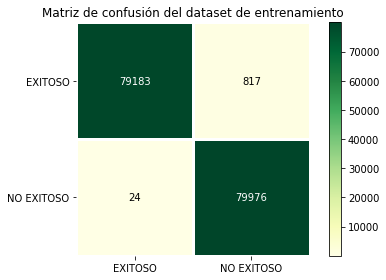

In [17]:
fig, ax = plt.subplots()

im, cbar = heatmap(cm_train, label_rendimiento, label_rendimiento, ax=ax,
                   cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

ax.set_title("Matriz de confusión del dataset de entrenamiento")
fig.tight_layout()
plt.show()

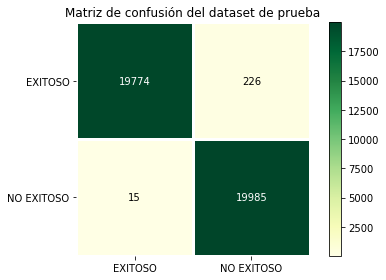

In [18]:
fig, ax = plt.subplots()

im, cbar = heatmap(cm_test, label_rendimiento, label_rendimiento, ax=ax,
                   cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

ax.set_title("Matriz de confusión del dataset de prueba")
fig.tight_layout()
plt.show()

In [19]:
datos_por_almacenar_exitoso = pd.read_sql_query("SELECT TOP(100000) * FROM [Difods_Analytics].dbo.DATA6_TRAIN_RNA WHERE RENDIMIENTO='EXITOSO'", conn)
datos_por_almacenar_no_exitoso = pd.read_sql_query("SELECT TOP(100000) * FROM [Difods_Analytics].dbo.DATA6_TRAIN_RNA WHERE RENDIMIENTO='NO EXITOSO'", conn)

In [20]:
datos_por_almacenar_total = datos_por_almacenar_exitoso.append(datos_por_almacenar_no_exitoso, ignore_index=True)

In [21]:
datos_por_almacenar_total['RENDIMIENTO'] = le_rendimiento.fit_transform(datos_por_almacenar_total['RENDIMIENTO'])
datos_por_almacenar_total['Descripcion_Cargo'] = le_cargo.fit_transform(datos_por_almacenar_total['Descripcion_Cargo'])
datos_por_almacenar_total['Descripcion_Subtipo_trabajador'] = le_subtipo_trabajador.fit_transform(datos_por_almacenar_total['Descripcion_Subtipo_trabajador'])
datos_por_almacenar_total['condicion_laboral'] = le_condicion_laboral.fit_transform(datos_por_almacenar_total['condicion_laboral'])
datos_por_almacenar_total['D_NIV_MOD'] = le_dniv.fit_transform(datos_por_almacenar_total['D_NIV_MOD'])
datos_por_almacenar_total['D_COD_CAR'] = le_dcodcar.fit_transform(datos_por_almacenar_total['D_COD_CAR'])
datos_por_almacenar_total['DAREACENSO'] = le_dareacenso.fit_transform(datos_por_almacenar_total['DAREACENSO'])
datos_por_almacenar_total['D_REGION'] = le_region.fit_transform(datos_por_almacenar_total['D_REGION'])
datos_por_almacenar_total['nivel'] = le_nivel.fit_transform(datos_por_almacenar_total['nivel'])
datos_por_almacenar_total['Forma de atención EIB'] = le_atencion_EIB.fit_transform(datos_por_almacenar_total['Forma de atención EIB'])
datos_por_almacenar_total['Lengua Originaria sin variante'] = le_lengua2.fit_transform(datos_por_almacenar_total['Lengua Originaria sin variante'])
datos_por_almacenar_total['Situación_Laboral'] = le_situacion_laboral.fit_transform(datos_por_almacenar_total['Situación_Laboral'])
datos_por_almacenar_total['sexo'] = le_sexo.fit_transform(datos_por_almacenar_total['sexo'])
datos_por_almacenar_total['d_forma'] = le_forma.fit_transform(datos_por_almacenar_total['d_forma'])
datos_por_almacenar_total['d_gestion'] = le_gestion.fit_transform(datos_por_almacenar_total['d_gestion'])
datos_por_almacenar_total['d_ges_dep'] = le_ges_dep.fit_transform(datos_por_almacenar_total['d_ges_dep'])
datos_por_almacenar_total['ruralidad_2021'] = le_ruralidad.fit_transform(datos_por_almacenar_total['ruralidad_2021'])
datos_por_almacenar_total['calidad_cobertura_2t2020'] = le_calidad_cobertura1.fit_transform(datos_por_almacenar_total['calidad_cobertura_2t2020'])
datos_por_almacenar_total['calidad_cobertura_internet_fijo'] = le_calidad_cobertura2.fit_transform(datos_por_almacenar_total['calidad_cobertura_internet_fijo'])
datos_por_almacenar_total['CONDICION_PUN'] = le_condicion_pun.fit_transform(datos_por_almacenar_total['CONDICION_PUN'])

In [22]:
datos_por_almacenar_total['Jornada_Laboral'] = scaler_jl.fit_transform(np.array(datos_por_almacenar_total['Jornada_Laboral']).reshape(-1, 1))
datos_por_almacenar_total['Numero de limitaciones'] = scaler_ndl.fit_transform(np.array(datos_por_almacenar_total['Numero de limitaciones']).reshape(-1, 1))
datos_por_almacenar_total['edad'] = scaler_edad.fit_transform(np.array(datos_por_almacenar_total['edad']).reshape(-1, 1))
datos_por_almacenar_total['FEEDBACK'] = scaler1.fit_transform(np.array(datos_por_almacenar_total['FEEDBACK']).reshape(-1, 1))
datos_por_almacenar_total['FORUM'] = scaler2.fit_transform(np.array(datos_por_almacenar_total['FORUM']).reshape(-1, 1))
datos_por_almacenar_total['RESOURCE'] = scaler3.fit_transform(np.array(datos_por_almacenar_total['RESOURCE']).reshape(-1, 1))
datos_por_almacenar_total['LABEL'] = scaler4.fit_transform(np.array(datos_por_almacenar_total['LABEL']).reshape(-1, 1))
datos_por_almacenar_total['QUIZ'] = scaler5.fit_transform(np.array(datos_por_almacenar_total['QUIZ']).reshape(-1, 1))
datos_por_almacenar_total['CHOICE'] = scaler6.fit_transform(np.array(datos_por_almacenar_total['CHOICE']).reshape(-1, 1))
datos_por_almacenar_total['PAGE'] = scaler7.fit_transform(np.array(datos_por_almacenar_total['PAGE']).reshape(-1, 1))
datos_por_almacenar_total['ASSIGN'] = scaler8.fit_transform(np.array(datos_por_almacenar_total['ASSIGN']).reshape(-1, 1))
datos_por_almacenar_total['URL'] = scaler9.fit_transform(np.array(datos_por_almacenar_total['URL']).reshape(-1, 1))
datos_por_almacenar_total['FINALGRADE'] = scaler10.fit_transform(np.array(datos_por_almacenar_total['FINALGRADE']).reshape(-1, 1))
datos_por_almacenar_total['PUNTAJE_PUN'] = scaler11.fit_transform(np.array(datos_por_almacenar_total['PUNTAJE_PUN']).reshape(-1, 1))

In [23]:
datos_por_almacenar_total.head(10)

,CURID,CURSO,IDNUMBER,RENDIMIENTO,Descripcion_Cargo,Descripcion_Subtipo_trabajador,escala,Jornada_Laboral,condicion_laboral,D_NIV_MOD,...,LABEL,QUIZ,CHOICE,PAGE,ASSIGN,URL,PRUEBA_ENTRADA,FINALGRADE,PUNTAJE_PUN,CONDICION_PUN
0,14,ICD5-2,41658672,0,4,1,1,0.736842,1,8,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.5,0.000000,2
1,14,ICD5-2,22498306,0,4,1,1,0.736842,0,9,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.7,0.624041,1
2,14,ICD5-2,40178296,0,9,1,1,0.736842,0,8,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.5,0.485934,1
3,15,ICD6-3,19868972,0,6,1,3,0.736842,1,7,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.6,0.000000,2
4,15,ICD6-3,44021580,0,4,1,1,0.526316,0,9,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.0,0.501279,1
5,15,ICD6-3,41789146,0,4,1,1,0.736842,0,8,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.0,0.544757,1
6,15,ICD6-3,19238979,0,4,1,2,0.736842,1,9,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.7,0.000000,2
7,15,ICD6-3,41081523,0,4,1,2,0.736842,1,9,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.6,0.000000,2
8,15,ICD6-3,41060759,0,6,1,1,0.736842,1,8,...,0.0,1.00,0.0,0.666667,0.0,1.000000,1,0.7,0.667519,0
9,6,GEVED-PCDG2,42450410,0,4,1,1,0.736842,1,8,...,0.0,0.75,0.0,0.000000,0.0,0.807692,1,0.3,0.000000,2


In [24]:
y_por_almacenar = datos_por_almacenar_total['RENDIMIENTO']
X_por_almacenar = datos_por_almacenar_total.iloc[:, 4::]

In [25]:
y_pred_por_almacenar = modelo_rna1.predict(X_por_almacenar)

In [26]:
y_pred_por_almacenar

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
yprob_pred_por_almacenar = modelo_rna1.predict_proba(X_por_almacenar)

In [28]:
yprob_pred_por_almacenar[:,0]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       2.69461917e-02, 2.15696916e-07, 3.23767744e-06])

In [29]:
datos_por_almacenar_filtrado = datos_por_almacenar_total[['CURSO', 'IDNUMBER', 'RENDIMIENTO']]

In [30]:
datos_por_almacenar_filtrado['PROBA_REND_PRED'] = np.round(yprob_pred_por_almacenar[:,0], 10)
datos_por_almacenar_filtrado['RENDIMIENTO_PRED'] = y_pred_por_almacenar

In [31]:
datos_por_almacenar_filtrado['RENDIMIENTO'] = datos_por_almacenar_filtrado['RENDIMIENTO'].apply(convertir_tag_rendimiento)
datos_por_almacenar_filtrado['RENDIMIENTO_PRED'] = datos_por_almacenar_filtrado['RENDIMIENTO_PRED'].apply(convertir_tag_rendimiento)

In [32]:
datos_por_almacenar_filtrado.head(10)

,CURSO,IDNUMBER,RENDIMIENTO,PROBA_REND_PRED,RENDIMIENTO_PRED
0,ICD5-2,41658672,EXITOSO,1.000000,EXITOSO
1,ICD5-2,22498306,EXITOSO,1.000000,EXITOSO
2,ICD5-2,40178296,EXITOSO,1.000000,EXITOSO
3,ICD6-3,19868972,EXITOSO,1.000000,EXITOSO
4,ICD6-3,44021580,EXITOSO,0.006566,NO EXITOSO
5,ICD6-3,41789146,EXITOSO,0.073311,NO EXITOSO
6,ICD6-3,19238979,EXITOSO,1.000000,EXITOSO
7,ICD6-3,41081523,EXITOSO,1.000000,EXITOSO
8,ICD6-3,41060759,EXITOSO,1.000000,EXITOSO
9,GEVED-PCDG2,42450410,EXITOSO,1.000000,EXITOSO


In [33]:
sql_query_insert = "INSERT INTO [Difods_Analytics].dbo.DATA_RESULTADOS_PREDICCION (CURSO,IDNUMBER,RENDIMIENTO,PROBA_REND_PRED,RENDIMIENTO_PRED) VALUES (?,?,?,?,?)"
val = datos_por_almacenar_filtrado[['CURSO','IDNUMBER', 'RENDIMIENTO', 'PROBA_REND_PRED', 'RENDIMIENTO_PRED']].values.tolist()

cursor.executemany(sql_query_insert, val)
conn.commit()

In [34]:
modelo_rna1.classes_

array([0, 1])

In [35]:
modelo_rna1.coefs_

[array([[-3.38620283e-315,  1.21534477e-001, -4.91725706e-001, ...,
         -2.12688859e-315, -6.96004328e-001,  1.72056642e-001],
        [-4.67631458e-315, -4.07567839e-002,  7.95009343e-002, ...,
         -2.65038231e-315, -1.25669526e-001,  5.09997235e-001],
        [-6.97148671e-316, -1.32039256e-001,  8.35138644e-001, ...,
         -4.00359399e-315,  5.12800138e-003, -5.90260750e-001],
        ...,
        [ 1.67975722e-315, -9.00429734e+000, -1.10972328e-001, ...,
         -1.49500536e-315, -3.98573857e-001, -7.74878076e-002],
        [-1.05548622e-315,  6.16400343e-002,  1.24983837e+000, ...,
         -4.92618079e-315,  5.14815248e-001, -1.78460529e+000],
        [-4.31415072e-315,  1.50054777e-001, -6.16730174e-001, ...,
          3.71277044e-315, -7.83730618e-001,  7.00067667e-001]]),
 array([[ 2.57994410e-317, -2.79321515e-315, -4.97732298e-315, ...,
         -4.26429318e-315, -5.26626449e-317, -2.60557036e-315],
        [-7.48944771e-001, -1.39383877e-001,  4.67341327e-002

In [36]:
datos_por_almacenar_filtrado.iloc[147759]

CURSO               ENRANI-IG1
IDNUMBER              80299158
RENDIMIENTO         NO EXITOSO
PROBA_REND_PRED       0.720052
RENDIMIENTO_PRED       EXITOSO
Name: 147759, dtype: object

In [ ]:
######################### Predicción de datos de últimos cursos ###############

In [20]:
datos_por_almacenar_exitoso = pd.read_sql_query("SELECT * FROM [Difods_Analytics].dbo.DATA8_TRAIN_RNA WHERE (RENDIMIENTO='EXITOSO' AND CURSO IN ('BSBRPG1-2022','EDN1-2022','EDN2-2022','EDN3-2022','EDN4-2022'))", conn)
datos_por_almacenar_no_exitoso = pd.read_sql_query("SELECT * FROM [Difods_Analytics].dbo.DATA8_TRAIN_RNA WHERE (RENDIMIENTO='NO EXITOSO' AND CURSO IN ('BSBRPG1-2022','EDN1-2022','EDN2-2022','EDN3-2022','EDN4-2022'))", conn)

In [21]:
datos_por_almacenar_total = datos_por_almacenar_exitoso.append(datos_por_almacenar_no_exitoso, ignore_index=True)

In [22]:
datos_por_almacenar_total['RENDIMIENTO'] = le_rendimiento.fit_transform(datos_por_almacenar_total['RENDIMIENTO'])
datos_por_almacenar_total['Descripcion_Cargo'] = le_cargo.fit_transform(datos_por_almacenar_total['Descripcion_Cargo'])
datos_por_almacenar_total['Descripcion_Subtipo_trabajador'] = le_subtipo_trabajador.fit_transform(datos_por_almacenar_total['Descripcion_Subtipo_trabajador'])
datos_por_almacenar_total['condicion_laboral'] = le_condicion_laboral.fit_transform(datos_por_almacenar_total['condicion_laboral'])
datos_por_almacenar_total['D_NIV_MOD'] = le_dniv.fit_transform(datos_por_almacenar_total['D_NIV_MOD'])
datos_por_almacenar_total['D_COD_CAR'] = le_dcodcar.fit_transform(datos_por_almacenar_total['D_COD_CAR'])
datos_por_almacenar_total['DAREACENSO'] = le_dareacenso.fit_transform(datos_por_almacenar_total['DAREACENSO'])
datos_por_almacenar_total['D_REGION'] = le_region.fit_transform(datos_por_almacenar_total['D_REGION'])
datos_por_almacenar_total['nivel'] = le_nivel.fit_transform(datos_por_almacenar_total['nivel'])
datos_por_almacenar_total['Forma de atención EIB'] = le_atencion_EIB.fit_transform(datos_por_almacenar_total['Forma de atención EIB'])
datos_por_almacenar_total['Lengua Originaria sin variante'] = le_lengua2.fit_transform(datos_por_almacenar_total['Lengua Originaria sin variante'])
datos_por_almacenar_total['Situación_Laboral'] = le_situacion_laboral.fit_transform(datos_por_almacenar_total['Situación_Laboral'])
datos_por_almacenar_total['sexo'] = le_sexo.fit_transform(datos_por_almacenar_total['sexo'])
datos_por_almacenar_total['d_forma'] = le_forma.fit_transform(datos_por_almacenar_total['d_forma'])
datos_por_almacenar_total['d_gestion'] = le_gestion.fit_transform(datos_por_almacenar_total['d_gestion'])
datos_por_almacenar_total['d_ges_dep'] = le_ges_dep.fit_transform(datos_por_almacenar_total['d_ges_dep'])
datos_por_almacenar_total['ruralidad_2021'] = le_ruralidad.fit_transform(datos_por_almacenar_total['ruralidad_2021'])
datos_por_almacenar_total['calidad_cobertura_2t2020'] = le_calidad_cobertura1.fit_transform(datos_por_almacenar_total['calidad_cobertura_2t2020'])
datos_por_almacenar_total['calidad_cobertura_internet_fijo'] = le_calidad_cobertura2.fit_transform(datos_por_almacenar_total['calidad_cobertura_internet_fijo'])
datos_por_almacenar_total['CONDICION_PUN'] = le_condicion_pun.fit_transform(datos_por_almacenar_total['CONDICION_PUN'])

In [23]:
datos_por_almacenar_total['Jornada_Laboral'] = scaler_jl.fit_transform(np.array(datos_por_almacenar_total['Jornada_Laboral']).reshape(-1, 1))
datos_por_almacenar_total['Numero de limitaciones'] = scaler_ndl.fit_transform(np.array(datos_por_almacenar_total['Numero de limitaciones']).reshape(-1, 1))
datos_por_almacenar_total['edad'] = scaler_edad.fit_transform(np.array(datos_por_almacenar_total['edad']).reshape(-1, 1))
datos_por_almacenar_total['FEEDBACK'] = scaler1.fit_transform(np.array(datos_por_almacenar_total['FEEDBACK']).reshape(-1, 1))
datos_por_almacenar_total['FORUM'] = scaler2.fit_transform(np.array(datos_por_almacenar_total['FORUM']).reshape(-1, 1))
datos_por_almacenar_total['RESOURCE'] = scaler3.fit_transform(np.array(datos_por_almacenar_total['RESOURCE']).reshape(-1, 1))
datos_por_almacenar_total['LABEL'] = scaler4.fit_transform(np.array(datos_por_almacenar_total['LABEL']).reshape(-1, 1))
datos_por_almacenar_total['QUIZ'] = scaler5.fit_transform(np.array(datos_por_almacenar_total['QUIZ']).reshape(-1, 1))
datos_por_almacenar_total['CHOICE'] = scaler6.fit_transform(np.array(datos_por_almacenar_total['CHOICE']).reshape(-1, 1))
datos_por_almacenar_total['PAGE'] = scaler7.fit_transform(np.array(datos_por_almacenar_total['PAGE']).reshape(-1, 1))
datos_por_almacenar_total['ASSIGN'] = scaler8.fit_transform(np.array(datos_por_almacenar_total['ASSIGN']).reshape(-1, 1))
datos_por_almacenar_total['URL'] = scaler9.fit_transform(np.array(datos_por_almacenar_total['URL']).reshape(-1, 1))
datos_por_almacenar_total['FINALGRADE'] = scaler10.fit_transform(np.array(datos_por_almacenar_total['FINALGRADE']).reshape(-1, 1))
datos_por_almacenar_total['PUNTAJE_PUN'] = scaler11.fit_transform(np.array(datos_por_almacenar_total['PUNTAJE_PUN']).reshape(-1, 1))

In [24]:
datos_por_almacenar_total.head(10)

,CAMPUS,CURID,CURSO,IDNUMBER,RENDIMIENTO,Descripcion_Cargo,Descripcion_Subtipo_trabajador,escala,Jornada_Laboral,condicion_laboral,...,CHOICE,PAGE,ASSIGN,URL,PRUEBA_ENTRADA,FINALGRADE,PUNTAJE_PUN,CONDICION_PUN,FORO_PRESENTACION,PUNTUACION_FORO
0,1,240,BSBRPG1-2022,41027359,0,4,1,2,0.72973,1,...,0.0,0.0,1.0,1.0,1,0.7,0.000000,2,0,0.0
1,1,240,BSBRPG1-2022,20073982,0,4,1,1,0.72973,1,...,0.0,0.0,1.0,1.0,1,0.6,0.788114,0,0,0.0
2,1,240,BSBRPG1-2022,33403836,0,4,1,6,0.72973,1,...,0.0,0.0,1.0,1.0,1,0.5,0.000000,2,0,0.0
3,1,240,BSBRPG1-2022,80051241,0,4,1,1,0.72973,0,...,0.0,0.0,1.0,1.0,1,0.1,0.462532,1,0,0.0
4,1,240,BSBRPG1-2022,02431806,0,4,1,1,0.72973,0,...,0.0,0.0,1.0,1.0,1,0.6,0.617571,1,0,0.0
5,1,240,BSBRPG1-2022,40327759,0,4,1,4,0.72973,1,...,0.0,0.0,1.0,1.0,1,0.5,0.000000,2,0,0.0
6,1,240,BSBRPG1-2022,06823388,0,8,1,1,0.72973,1,...,0.0,0.0,1.0,1.0,1,0.5,0.000000,2,0,0.0
7,1,240,BSBRPG1-2022,22297829,0,4,1,2,0.72973,1,...,0.0,0.0,1.0,1.0,1,1.0,0.000000,2,0,0.0
8,1,240,BSBRPG1-2022,16168618,0,4,1,1,0.72973,0,...,0.0,0.0,1.0,1.0,1,0.6,0.571059,1,0,0.0
9,1,240,BSBRPG1-2022,46081218,0,10,1,1,0.72973,1,...,0.0,0.0,1.0,1.0,1,0.6,0.000000,2,0,0.0


In [25]:
y_por_almacenar = datos_por_almacenar_total['RENDIMIENTO']
X_por_almacenar = datos_por_almacenar_total.iloc[:, 5::]

In [26]:
y_pred_por_almacenar = modelo_rna1.predict(X_por_almacenar)

In [27]:
yprob_pred_por_almacenar = modelo_rna1.predict_proba(X_por_almacenar)

In [28]:
datos_por_almacenar_filtrado = datos_por_almacenar_total[['CURSO', 'IDNUMBER', 'RENDIMIENTO']]

In [29]:
datos_por_almacenar_filtrado['PROBA_REND_PRED'] = np.round(yprob_pred_por_almacenar[:,0], 10)
datos_por_almacenar_filtrado['RENDIMIENTO_PRED'] = y_pred_por_almacenar

In [30]:
datos_por_almacenar_filtrado['RENDIMIENTO'] = datos_por_almacenar_filtrado['RENDIMIENTO'].apply(convertir_tag_rendimiento)
datos_por_almacenar_filtrado['RENDIMIENTO_PRED'] = datos_por_almacenar_filtrado['RENDIMIENTO_PRED'].apply(convertir_tag_rendimiento)

In [31]:
datos_por_almacenar_filtrado.head(10)

,CURSO,IDNUMBER,RENDIMIENTO,PROBA_REND_PRED,RENDIMIENTO_PRED
0,BSBRPG1-2022,41027359,EXITOSO,1.000000,EXITOSO
1,BSBRPG1-2022,20073982,EXITOSO,1.000000,EXITOSO
2,BSBRPG1-2022,33403836,EXITOSO,1.000000,EXITOSO
3,BSBRPG1-2022,80051241,EXITOSO,0.039052,NO EXITOSO
4,BSBRPG1-2022,02431806,EXITOSO,1.000000,EXITOSO
5,BSBRPG1-2022,40327759,EXITOSO,1.000000,EXITOSO
6,BSBRPG1-2022,06823388,EXITOSO,1.000000,EXITOSO
7,BSBRPG1-2022,22297829,EXITOSO,1.000000,EXITOSO
8,BSBRPG1-2022,16168618,EXITOSO,1.000000,EXITOSO
9,BSBRPG1-2022,46081218,EXITOSO,1.000000,EXITOSO


In [32]:
sql_query_insert = "INSERT INTO [Difods_Analytics].dbo.DATA2_RESULTADOS_PREDICCION (CURSO,IDNUMBER,RENDIMIENTO,PROBA_REND_PRED,RENDIMIENTO_PRED) VALUES (?,?,?,?,?)"
val = datos_por_almacenar_filtrado[['CURSO','IDNUMBER', 'RENDIMIENTO', 'PROBA_REND_PRED', 'RENDIMIENTO_PRED']].values.tolist()

cursor.executemany(sql_query_insert, val)
conn.commit()